In [1]:
import numpy as np
import os
import math
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import csv
import json
from scipy.stats import wasserstein_distance
import statistics
from tqdm import tqdm
import shutil
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
mappath = "results"
categories = ['monsters killed','treasures collected','time taken',
              'win rate', 'potions consumed']
maps = [100, 101, 102, 201, 202]
personas=["MK", "R", "TC"]
os.makedirs("images", exist_ok=True)
all_results = []

def getGraphStats(mapfile):
    results = []
    for persona in personas:
        monstersKilled = 0
        treasuresCollected = 0
        potionsTaken = 0
        timeTaken = 0
        wins = 0
        temp_mapfile = f"{mapfile}{persona}.json"
        with open(temp_mapfile) as f:
            allstats = json.load(f)
        for entry in allstats:
            levelReport = entry["levelReport"]
            monstersKilled += levelReport["monsterKills"]
            treasuresCollected += levelReport["treasuresCollected"]
            potionsTaken += levelReport["potionsTaken"]
            timeTaken += levelReport["timeTaken"]
            wins += int(levelReport["exitUtility"])
        
        temp_mapfile = f"{mapfile}{persona}_flawed.json"
        with open(temp_mapfile) as f:
            flawedstats = json.load(f)
        for entry in flawedstats:
            levelReport = entry["levelReport"]
            monstersKilled += levelReport["monsterKills"]
            treasuresCollected += levelReport["treasuresCollected"]
            potionsTaken += levelReport["potionsTaken"]
            timeTaken += levelReport["timeTaken"]
            wins += int(levelReport["exitUtility"])

        totalMonsters = levelReport["totalMonsters"]
        totalPotions = levelReport["totalPotions"]
        totalTreasures = levelReport["totalTreasures"]
        totalTime = 20000
        totalGames = len(allstats) + len(flawedstats)

        # average
        monstersKilled /= totalGames
        treasuresCollected /= totalGames
        potionsTaken /= totalGames
        timeTaken /= totalGames

        # normalize against max
        if totalMonsters != 0:
            monstersKilled /= totalMonsters
        else:
            monstersKilled = 0
        if totalTreasures != 0:
            treasuresCollected /= totalTreasures
        else:
            treasuresCollected = 0
        if totalPotions != 0:
            potionsTaken /= totalPotions
        else:
            potionsTaken = 0

        timeTaken /= totalTime
        wins /= totalGames

        results.append({"persona": persona, "monstersKilled": monstersKilled, "treasuresCollected": treasuresCollected, "potionsTaken": potionsTaken, "timeTaken": timeTaken, "winRate": wins})
    return results

    

In [3]:

# fig = make_subplots(rows=rows, cols=cols, specs=[[{'type': 'polar'}]*3]*4)
# for i in maps:
#     x = 1
#     y = 1
#     mapname = f"map{i}"
#     nowpath = os.path.join(mappath, mapname)
#     results = getGraphStats(nowpath)
#     all_results.append(results)
#     winRates = 0
    
#     fig = go.Figure()
#     for persona in results:
#         fig.add_trace(
#             go.Scatterpolar(
#                 r=[
#                     persona["monstersKilled"], 
#                     persona["treasuresCollected"], 
#                     persona["timeTaken"], 
#                     persona["winRate"], 
#                     persona["potionsTaken"]],
#                 theta=categories,
#                 fill='toself',
#                 name=f"{persona['persona']}: {persona['winRate']}",
#             ),
#         )
#         winRates += persona["winRate"]
#         print(persona)

#     # fig.write_image(f"images/{mapname}.svg")
#     fig.update_layout(
#     title_text=f"{winRates / len(results)}"
#     )
#     fig.write_image(f"images/{mapname}.png")

wr = []
mk = []
tc = []
pt = []
allst = []

for mapentry in all_results:
    wrrow = []
    mkrow = []
    tcrow = []
    ptrow = []
    allstrow = []
    for persona in mapentry:
        print(persona)
        wrrow.append(persona["winRate"])
        mkrow.append(persona["monstersKilled"])
        tcrow.append(persona["treasuresCollected"])
        ptrow.append(persona["potionsTaken"])
        allstrow += [
            persona["winRate"],
            persona["monstersKilled"],
            persona["treasuresCollected"],
            persona["potionsTaken"]
        ]
    wr.append(wrrow)
    mk.append(mkrow)
    tc.append(tcrow)
    pt.append(ptrow)
    allst.append(allstrow)

print("Win Rates")
print(wr)
print("Monsters Slain")
print(mk)
print("Treasures Collected")
print(tc)
print("Potions Taken")
print(pt)
print("All stats")
print(allst)

Win Rates
[]
Monsters Slain
[]
Treasures Collected
[]
Potions Taken
[]
All stats
[]


In [4]:
def aggPersonaStats(mech, d_persona, invert=False):
    maploc = "results"
    persona_frequencies = []
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if (persona == d_persona and not invert) or invert:
                    if mech in entry["frequencies"]:
                        persona_frequencies.append(entry["frequencies"][mech])
                    else:
                        persona_frequencies.append(0)
            temp_mapfile = f"{mapfile}{persona}_flawed.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if (persona == d_persona and not invert) or invert:
                    if mech in entry["frequencies"]:
                        persona_frequencies.append(entry["frequencies"][mech])
                    else:
                        persona_frequencies.append(0)
                
    average = statistics.mean(persona_frequencies)
    stdev = statistics.stdev(persona_frequencies)
    return persona_frequencies, average, stdev

def aggResultStats(mech, result, invert=False):
    maploc = "results"
    wr_frequencies = []
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if result == int(entry["levelReport"]["exitUtility"] and not invert) or (invert):
                    if mech in entry["frequencies"]:
                        wr_frequencies.append(entry["frequencies"][mech]) 
                    else:
                        wr_frequencies.append(0) 
            temp_mapfile = f"{mapfile}{persona}_flawed.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if result == int(entry["levelReport"]["exitUtility"] and not invert) or (invert):
                    if mech in entry["frequencies"]:
                        wr_frequencies.append(entry["frequencies"][mech]) 
                    else:
                        wr_frequencies.append(0) 
    
    average = statistics.mean(wr_frequencies)
    stdev = statistics.stdev(wr_frequencies)
    return wr_frequencies, average, stdev


def getUniques():
    maploc = "results"
    uniques = set()
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        print(mapfile)
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                for key in entry["frequencies"].keys():
                    uniques.add(key)
    return list(uniques)


def get_mech_max(mech):
    maploc = "results"
    maximum = 0
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if mech in entry["frequencies"] and maximum < entry["frequencies"][mech]:
                    maximum = entry["frequencies"][mech]
    return maximum

In [5]:
unique_mechs = getUniques()

def calculate_stats(persona):
    x_mech = []
    y_mech = []

    for mech in unique_mechs:
        agent_freq_y, agent_avg_y, _ = aggPersonaStats(mech, persona)
        all_freq_y, all_avg_y, _ = aggPersonaStats(mech, persona, invert=True)

        win_freq_x, win_avg_x, _ = aggResultStats(mech, result=1)
        all_freq_x, all_avg_x, _ = aggResultStats(mech, result=1, invert=True) 

        w_dist_x = wasserstein_distance(all_freq_x, win_freq_x)
        x_sign = math.copysign(1, win_avg_x - all_avg_x)

        w_dist_y = wasserstein_distance(all_freq_y, agent_freq_y)
        y_sign = math.copysign(1, agent_avg_y - all_avg_y)
        
        mech_max = get_mech_max(mech)

        w_dist_x = ((w_dist_x) / (mech_max))
        w_dist_y = ((w_dist_y) / (mech_max))

        x_mech.append(w_dist_x * x_sign)
        y_mech.append(w_dist_y * y_sign)
    return x_mech, y_mech

results\map100
results\map101
results\map102
results\map201
results\map202


In [6]:

# level_data = {}
# scores = []
# y_mechs = []
# x_mechs = []
# for i, persona in enumerate(tqdm(personas)):
#     x, y = calculate_stats(persona)
#     scores.append(persona) 
#     y_mechs.append(y)
#     x_mechs.append(x)

#     level_data = (scores, x_mechs, y_mechs)

#     print(persona)
#     print(y)



In [7]:
val = level_data
scores = val[0]
x_mechs = val[1]
y_mechs = val[2]
data = []
banned_mechs = ["MoveDown", "MoveRight", "MoveLeft", "MoveUp", "None", "BlobPotion", "OgreTreasure"]
for idx, score in enumerate(tqdm(scores)):
    agent = score
    data.append((score[0], x_mechs[idx], y_mechs[idx]))


colors = ['#FD3216', '#00FE35', '#6A76FC', '#FED4C4', '#FE00CE', '#0DF9FF', '#F6F926', '#FF9616', '#479B55', '#EEA6FB', '#DC587D', '#D626FF', '#6E899C', '#00B5F7', '#B68E00', '#C9FBE5', '#FF0092', '#22FFA7', '#E3EE9E', '#86CE00', '#BC7196', '#7E7DCD', '#FC6955', '#E48F72']
fig = go.Figure()

fig.add_shape(
    type="line",
    x0=-1, y0=0, x1=1, y1=0,
    line=dict(color="Black"),
    layer="below",
)
fig.add_shape(
    type="line",
    x0=0, y0=-1, x1=0, y1=1,
    line=dict(color="Black"),
    layer="below",
)
# green
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="#43a047"),
    fillcolor="#76d275",
    layer="below",
    opacity=0.5
)
#red
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=-1, y1=-1,
    line=dict(color="#e53935"),
    fillcolor="#ff6f60",
    layer="below",
    opacity=0.5
)
#blue
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=1, y1=-1,
    line=dict(color="#2196f3"),
    fillcolor="#6ec6ff",
    layer="below",
    opacity=0.5
)
#yello
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=-1, y1=1,
    line=dict(color="#fbc02d"),
    fillcolor="#fff263",
    layer="below",
    opacity=0.5
)

# x = [0 for i in range(len(y))]

for idx, entry in enumerate(data):
    x = entry[1]
    y = entry[2]
    x_new = []
    y_new = []
    unique_mechs_new = []
    for i in range(len(x)):
        if not pd.isna(y[i]) and unique_mechs[i] not in banned_mechs:
            x_new.append(x[i])
            y_new.append(y[i])
            unique_mechs_new.append(unique_mechs[i])
    fig.add_trace(
        go.Scatter(
            x=x_new,
            y=y_new,
            mode='markers',
            marker_symbol=idx,
            marker=dict(
                color=colors,
                size=30 - (5 + 4*idx),
                line=dict(width=1,color='DarkSlateGrey')),
            text=unique_mechs_new,
            name=entry[0]
        )
    )


fig.update_layout(
    # title='Mechanic Axis of Alignment: {}'.format(game),
    showlegend=True,
    font=dict(
        family="Arial",
        size=24,
        color="Black"
    ),
    xaxis_range=[-5, 5],
    yaxis_range=[-1, 1]
)
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black', showgrid=False)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black', showgrid=False)
os.makedirs('graphs', exist_ok=True)
fig.write_html(os.path.join('graphs', 'minidungeons.html'))

NameError: name 'level_data' is not defined

In [ ]:
for idx, score in enumerate(tqdm(scores)):
    agent = score[0]
    print(f"********\n{score}")
    for u_id, mech in enumerate(unique_mechs):
        if y_mechs[idx][u_id] > 0 and mech not in banned_mechs:
            print(f"{mech}: {y_mechs[idx][u_id]}")


NameError: name 'scores' is not defined

# User Study Section

In [8]:

# Read in a user's data, build a distribution out of it
def get_user_stats(user_id, mech):
    persona_frequencies = []
    with open(f"results_study/{user_id}.json") as f:
        allstats = json.load(f)
    levels_string = allstats.get("results")
    for entry in levels_string:
        print(entry.keys())
        if mech in entry["frequencies"]:
            persona_frequencies.append(entry["frequencies"][mech])
        else:
            persona_frequencies.append(0)
        
    average = statistics.mean(persona_frequencies)
    stdev = statistics.stdev(persona_frequencies)
    return persona_frequencies, average, stdev

user_id = "0ad0fd5c-fca9-11eb-b245-64006a7cc0f7"
freq, avg, stdev = get_user_stats(user_id, "ReachStairs")
print(freq, avg, stdev)

dict_keys(['mechanics', 'frequencies', 'levelReport', 'positions', 'levelStates', 'map_number'])
dict_keys(['mechanics', 'frequencies', 'levelReport', 'positions', 'levelStates', 'map_number'])
dict_keys(['mechanics', 'frequencies', 'levelReport', 'positions', 'levelStates', 'map_number'])
[1, 1, 1] 1 0.0


In [9]:
def find_good_playtraces(directory, valid_study_path="valid_study", invalid_study_path="invalid_study"):
    point_chart = {"Never": 0, "Rarely": 1, "Sometimes": 2, "Often": 3, "Always": 4}
    valid, invalid = 0, 0
    os.makedirs("valid_study", exist_ok=True)
    os.makedirs("invalid_study", exist_ok=True)
    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            with open(filepath, "r") as f:
                userdata = json.load(f)
                # print(f"{filepath}")
                points = 0
                for i in range(2, 11):
                    value = userdata.get(f"Q{i}")
                    # print(f"Q{i}: {value}")
                    point = point_chart.get(value)
                    points += point
                if points > 0:
                    valid += 1
                    shutil.copy(filepath, os.path.join(valid_study_path, filename))
                else:
                    invalid += 1
                    shutil.copy(filepath, os.path.join(invalid_study_path, filename))
    print(f"valid: {valid} | invalid: {invalid}")

In [10]:
find_good_playtraces("results_study")

valid: 210 | invalid: 98


In [11]:
agent_freq = []
agent_avg = []
win_freq= []
win_avg = []

def aggUserStats(mech, user_uuid, invert=False):
    user_frequencies = []
    # just for user if invert is false
    maploc = "valid_study"
    userfile = os.path.join(maploc, f"{user_uuid}.json")
    results = None
    with open(userfile, "r") as f:
        userdata = json.load(f)
        results = userdata.get("results")
    for entry in results:
        if mech in entry["frequencies"]:
            user_frequencies.append(entry["frequencies"][mech])
        else:
            user_frequencies.append(0)   
    
    if invert:
        if len(agent_freq) == 0:
            maploc = "results"
            # if invert is true, then we read in everything but user
            for i in maps:
                mapfile = os.path.join(maploc, f"map{i}")
                for persona in personas:
                    temp_mapfile = f"{mapfile}{persona}.json"
                    with open(temp_mapfile) as f:
                        allstats = json.load(f)
                    for entry in allstats:
                        if mech in entry["frequencies"]:
                            user_frequencies.append(entry["frequencies"][mech])
                            agent_freq.append(entry["frequencies"][mech])
                        else:
                            user_frequencies.append(0)
                            agent_freq.append(0)
                    temp_mapfile = f"{mapfile}{persona}_flawed.json"
                    with open(temp_mapfile) as f:
                        allstats = json.load(f)
                    for entry in allstats:
                        if mech in entry["frequencies"]:
                            user_frequencies.append(entry["frequencies"][mech])
                            agent_freq.append(entry["frequencies"][mech])
                        else:
                            user_frequencies.append(0)
                            agent_freq.append(0)
        else:
            user_frequencies += agent_freq       
    average = statistics.mean(user_frequencies)
    stdev = statistics.stdev(user_frequencies)
    return user_frequencies, average, stdev

def aggResultUserStats(mech, result=1, invert=False):
    maploc = "results"
    wr_frequencies = []
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if result == int(entry["levelReport"]["exitUtility"] and not invert) or (invert):
                    if mech in entry["frequencies"]:
                        wr_frequencies.append(entry["frequencies"][mech]) 
                    else:
                        wr_frequencies.append(0) 
            temp_mapfile = f"{mapfile}{persona}_flawed.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if result == int(entry["levelReport"]["exitUtility"] and not invert) or (invert):
                    if mech in entry["frequencies"]:
                        wr_frequencies.append(entry["frequencies"][mech]) 
                    else:
                        wr_frequencies.append(0) 
    
    average = statistics.mean(wr_frequencies)
    stdev = statistics.stdev(wr_frequencies)
    return wr_frequencies, average, stdev

def get_mech_max_users(mech, user_uuid):
    maploc = "results"
    maximum = 0
    for i in maps:
        mapfile = os.path.join(maploc, f"map{i}")
        for persona in personas:
            temp_mapfile = f"{mapfile}{persona}.json"
            with open(temp_mapfile) as f:
                allstats = json.load(f)
            for entry in allstats:
                if mech in entry["frequencies"] and maximum < entry["frequencies"][mech]:
                    maximum = entry["frequencies"][mech]
    maploc = "valid_study"
    userfile = os.path.join(maploc, f"{user_uuid}.json")
    results = None
    with open(userfile, "r") as f:
        userdata = json.load(f)
        results = userdata.get("results")
    for entry in results:
        if mech in entry["frequencies"] and maximum < entry["frequencies"][mech]:
            maximum = entry["frequencies"][mech]
    return maximum
def calculate_stats_user(user_uuid):
    x_mech = []
    y_mech = []
    all_freq_x, all_avg_x, win_freq_x, win_avg_x = None, None, None, None

    for mech in unique_mechs:
        agent_freq_y, agent_avg_y, _ = aggUserStats(mech, user_uuid)
        all_freq_y, all_avg_y, _ = aggUserStats(mech, user_uuid, invert=True)

        if all_freq_x is None:
            win_freq_x, win_avg_x, _ = aggResultUserStats(mech, result=1)
            all_freq_x, all_avg_x, _ = aggResultUserStats(mech, result=1, invert=True) 

        w_dist_x = wasserstein_distance(all_freq_x, win_freq_x)
        x_sign = math.copysign(1, win_avg_x - all_avg_x)

        w_dist_y = wasserstein_distance(all_freq_y, agent_freq_y)
        y_sign = math.copysign(1, agent_avg_y - all_avg_y)
        
        mech_max = get_mech_max_users(mech, user_uuid)

        w_dist_x = ((w_dist_x) / (mech_max))
        w_dist_y = ((w_dist_y) / (mech_max))

        x_mech.append(w_dist_x * x_sign)
        y_mech.append(w_dist_y * y_sign)
    return x_mech, y_mech


In [12]:
# Debug cell
mech = "CollectPotion"
print(mech)

agent_freq_y, agent_avg_y, _ = aggUserStats(mech, "0ad0fd5c-fca9-11eb-b245-64006a7cc0f7")
all_freq_y, all_avg_y, _ = aggUserStats(mech, "0ad0fd5c-fca9-11eb-b245-64006a7cc0f7", invert=True)

w_dist_y = wasserstein_distance(all_freq_y, agent_freq_y)
y_sign = math.copysign(1, agent_avg_y - all_avg_y)

# print(f"user freq: {agent_freq_y}")
# print(f"user avg: {agent_avg_y}")

# print(f"all freq: {all_freq_y}")
# print(f"all avg: {all_avg_y}")

# print(f"w dist: {w_dist_y}")



CollectPotion


In [13]:
stats = calculate_stats_user("0ad0fd5c-fca9-11eb-b245-64006a7cc0f7")


In [14]:
stats

([0.328,
  0.05466666666666667,
  0.082,
  0.036444444444444446,
  0.164,
  0.164,
  0.328,
  0.164,
  0.10933333333333334,
  0.02523076923076923,
  0.04685714285714286,
  0.164,
  0.164],
 [0.8368298368298368,
  0.5754800754800755,
  0.12595737595737594,
  0.49465349465349473,
  0.227938727938728,
  -0.10506160506160506,
  0.17082917082917082,
  0.08541458541458541,
  0.26295926295926303,
  0.39368323983708603,
  0.4932686361257791,
  0.2519147519147519,
  0.560939060939061])

In [15]:
level_data = {}
scores = []
y_mechs = []
x_mechs = []
user_uuids = []

playstyles = []
user_entries = []
x = None
for root, dirs, files in os.walk("valid_study"):
    for filename in files:
        uuid = filename.split(".")[0]
        user_uuids.append(uuid)
for i, persona in enumerate(tqdm(personas)):
    x, y = calculate_stats(persona)
    scores.append(persona) 
    y_mechs.append(y)
    x_mechs.append(x)
    playstyles.append((persona, x, y))

    
for user_uuid in tqdm(user_uuids):
    _, y = calculate_stats_user(user_uuid)
    scores.append(user_uuid)
    y_mechs.append(y)
    x_mechs.append(x)
    user_entries.append((user_uuid, x, y))


100%|██████████| 210/210 [11:55<00:00,  3.41s/it]


In [16]:
scores

['MK',
 'R',
 'TC',
 '009e555e-fa39-11eb-87d2-64006a7cc0f7',
 '01e7a134-fa81-11eb-a839-64006a7cc0f7',
 '0230dab6-fa2c-11eb-a71e-64006a7cc0f7',
 '033a3daa-fd4a-11eb-b167-64006a7cc0f7',
 '061d2140-fa52-11eb-87d2-64006a7cc0f7',
 '06b7f180-fa38-11eb-87d2-64006a7cc0f7',
 '07c2d5ac-fa67-11eb-9123-64006a7cc0f7',
 '0923e8c8-fa44-11eb-87d2-64006a7cc0f7',
 '0ad0fd5c-fca9-11eb-b245-64006a7cc0f7',
 '0dcf0284-fa41-11eb-87d2-64006a7cc0f7',
 '0dea900a-fa71-11eb-bad9-64006a7cc0f7',
 '13158bf8-060a-11ec-a4f5-64006a7cc0f7',
 '13368fd0-fa6e-11eb-9123-64006a7cc0f7',
 '15091d2c-fa56-11eb-87d2-64006a7cc0f7',
 '1558391c-fa37-11eb-87d2-64006a7cc0f7',
 '155ee134-fc5f-11eb-b245-64006a7cc0f7',
 '1a19de14-fa5b-11eb-9d4f-64006a7cc0f7',
 '1b939a36-fa3e-11eb-87d2-64006a7cc0f7',
 '1e4d6e52-fd43-11eb-b167-64006a7cc0f7',
 '1ed570ee-fd49-11eb-b167-64006a7cc0f7',
 '1f318adc-fa65-11eb-9123-64006a7cc0f7',
 '21873bd4-fd48-11eb-b167-64006a7cc0f7',
 '21d9f168-fa5e-11eb-9d4f-64006a7cc0f7',
 '21e8843a-fd33-11eb-b167-64006a7cc0f

In [17]:
data = []
banned_mechs = ["MoveDown", "MoveRight", "MoveLeft", "MoveUp", "None", "BlobPotion", "OgreTreasure"]
for idx, score in enumerate(tqdm(scores)):
    agent = score
    data.append((score, x_mechs[idx], y_mechs[idx]))


colors = ['#FD3216', '#00FE35', '#6A76FC', '#FED4C4', '#FE00CE', '#0DF9FF', '#F6F926', '#FF9616', '#479B55', '#EEA6FB', '#DC587D', '#D626FF', '#6E899C', '#00B5F7', '#B68E00', '#C9FBE5', '#FF0092', '#22FFA7', '#E3EE9E', '#86CE00', '#BC7196', '#7E7DCD', '#FC6955', '#E48F72']
fig = go.Figure()

fig.add_shape(
    type="line",
    x0=-1, y0=0, x1=1, y1=0,
    line=dict(color="Black"),
    layer="below",
)
fig.add_shape(
    type="line",
    x0=0, y0=-1, x1=0, y1=1,
    line=dict(color="Black"),
    layer="below",
)
# green
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="#43a047"),
    fillcolor="#76d275",
    layer="below",
    opacity=0.5
)
#red
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=-1, y1=-1,
    line=dict(color="#e53935"),
    fillcolor="#ff6f60",
    layer="below",
    opacity=0.5
)
#blue
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=1, y1=-1,
    line=dict(color="#2196f3"),
    fillcolor="#6ec6ff",
    layer="below",
    opacity=0.5
)
#yello
fig.add_shape(
    type="rect",
    x0=0, y0=0, x1=-1, y1=1,
    line=dict(color="#fbc02d"),
    fillcolor="#fff263",
    layer="below",
    opacity=0.5
)

# x = [0 for i in range(len(y))]

for idx, entry in enumerate(data):
    x = entry[1]
    y = entry[2]
    x_new = []
    y_new = []
    unique_mechs_new = []
    for i in range(len(x)):
        if not pd.isna(y[i]) and unique_mechs[i] not in banned_mechs:
            x_new.append(x[i])
            y_new.append(y[i])
            unique_mechs_new.append(unique_mechs[i])
    print(entry[0])
    fig.add_trace(
        go.Scatter(
            x=x_new,
            y=y_new,
            mode='markers',
            marker_symbol=2,
            marker=dict(
                color=colors,
                size=30 - (5 + 4),
                line=dict(width=1,color='DarkSlateGrey')),
            text=unique_mechs_new,
            name=entry[0]
        )
    )


fig.update_layout(
    # title='Mechanic Axis of Alignment: {}'.format(game),
    showlegend=True,
    font=dict(
        family="Arial",
        size=24,
        color="Black"
    ),
    xaxis_range=[-1, 1],
    yaxis_range=[-1, 1]
)
fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black', showgrid=False)
fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Black', showgrid=False)
os.makedirs('graphs', exist_ok=True)
fig.write_html(os.path.join('graphs', 'minidungeons.html'))

100%|██████████| 213/213 [00:00<00:00, 213371.57it/s]


MK
R
TC
009e555e-fa39-11eb-87d2-64006a7cc0f7
01e7a134-fa81-11eb-a839-64006a7cc0f7
0230dab6-fa2c-11eb-a71e-64006a7cc0f7
033a3daa-fd4a-11eb-b167-64006a7cc0f7
061d2140-fa52-11eb-87d2-64006a7cc0f7
06b7f180-fa38-11eb-87d2-64006a7cc0f7
07c2d5ac-fa67-11eb-9123-64006a7cc0f7
0923e8c8-fa44-11eb-87d2-64006a7cc0f7
0ad0fd5c-fca9-11eb-b245-64006a7cc0f7
0dcf0284-fa41-11eb-87d2-64006a7cc0f7
0dea900a-fa71-11eb-bad9-64006a7cc0f7
13158bf8-060a-11ec-a4f5-64006a7cc0f7
13368fd0-fa6e-11eb-9123-64006a7cc0f7
15091d2c-fa56-11eb-87d2-64006a7cc0f7
1558391c-fa37-11eb-87d2-64006a7cc0f7
155ee134-fc5f-11eb-b245-64006a7cc0f7
1a19de14-fa5b-11eb-9d4f-64006a7cc0f7
1b939a36-fa3e-11eb-87d2-64006a7cc0f7
1e4d6e52-fd43-11eb-b167-64006a7cc0f7
1ed570ee-fd49-11eb-b167-64006a7cc0f7
1f318adc-fa65-11eb-9123-64006a7cc0f7
21873bd4-fd48-11eb-b167-64006a7cc0f7
21d9f168-fa5e-11eb-9d4f-64006a7cc0f7
21e8843a-fd33-11eb-b167-64006a7cc0f7
229e5238-fa18-11eb-9d22-64006a7cc0f7
22d12884-fa7c-11eb-be81-64006a7cc0f7
22e3292c-fa26-11eb-9d22-64006a

In [29]:
data = []
for entry in user_entries:
    # compare every playstyle to this entry
    y_human = entry[2]
    h_array = np.array(y_human)
    row = [f"{entry[0]}"]
    for playstyle in playstyles:
        y_playstyle = playstyle[2]
        p_array = np.array(y_playstyle)
        c_sim = cosine_similarity([h_array], [p_array])
        row.append(c_sim[0,0])
    data.append(row)
df = pd.DataFrame(data, columns=["User", "MK", "R", "TC"])
df.to_csv("cosine_sim.csv")
df = df.set_index("User")


for playstyle in playstyles:
    for playstyle2 in playstyles:
        y_playstyle = playstyle[2]
        y_playstyle_2 = playstyle2[2]
        c_sim = cosine_similarity([y_playstyle], [y_playstyle_2])

        print(f"{playstyle[0]} and {playstyle2[0]}: {c_sim[0,0]}")

MK and MK: 1.0
MK and R: -0.7025505403205881
MK and TC: -0.03847287422310905
R and MK: -0.7025505403205881
R and R: 0.9999999999999998
R and TC: -0.6834563940009837
TC and MK: -0.03847287422310905
TC and R: -0.6834563940009837
TC and TC: 0.9999999999999998


In [24]:
df

,MK,R,TC,1,2,3,Total Wins,Avg
User,,,,,,,,
009e555e-fa39-11eb-87d2-64006a7cc0f7,0.321830,-0.528101,0.419955,0.0,1.0,1.0,2.0,0.666667
01e7a134-fa81-11eb-a839-64006a7cc0f7,0.021222,-0.287190,0.382355,1.0,0.0,1.0,2.0,0.666667
0230dab6-fa2c-11eb-a71e-64006a7cc0f7,0.163372,-0.126752,-0.006074,1.0,1.0,0.0,2.0,0.666667
033a3daa-fd4a-11eb-b167-64006a7cc0f7,-0.320975,0.370757,-0.194543,1.0,1.0,1.0,3.0,1.000000
061d2140-fa52-11eb-87d2-64006a7cc0f7,-0.266342,0.250849,-0.085826,1.0,1.0,1.0,3.0,1.000000
...,...,...,...,...,...,...,...,...
fb297598-fa71-11eb-be81-64006a7cc0f7,-0.046246,0.005120,0.026598,1.0,1.0,1.0,3.0,1.000000
fd52f7f4-fa7b-11eb-be81-64006a7cc0f7,0.071201,0.116452,-0.250914,1.0,1.0,1.0,3.0,1.000000
fd5cd500-fa2e-11eb-87d2-64006a7cc0f7,0.214620,-0.355388,0.286727,1.0,1.0,1.0,3.0,1.000000


# Win/Lose Breakdown

In [40]:
results = []
def win_lose(user_uuid):
    with open(f"valid_study/{user_uuid}.json") as f:
        userdata = json.load(f)
        results = userdata.get("results")
    outcomes = []
    for entry in results:
        level_report = entry.get('levelReport')
        outcome = level_report.get("exitUtility")
        outcomes.append(outcome)
    return outcomes
for user_uuid in tqdm(user_uuids):
    outcomes = win_lose(user_uuid)
    row = [user_uuid]
    row += outcomes
    total = sum(outcomes)
    row.append(total)
    row.append(total / len(outcomes))
    results.append(row)
outcome_df = pd.DataFrame(results, columns=["User", "1", "2", "3", "Total Wins", "Avg"])
outcome_df = outcome_df.set_index("User")
df = df.join(outcome_df)
df.to_csv("compiled.csv")

100%|██████████| 210/210 [00:00<00:00, 2365.89it/s]


# Interesting subsets of players
1. Players that don't abide by any playstyle (all are around 0)
    - Players that don't abide by any playstyle and win a lot
2. Players that entirely oppose a playstyle (-0.5 or greater in any category)
3. Players that are completionists (MK and TC)
4. Others?

In [41]:
# Players that dont abide by any playstyle (all are around 0)
# epsilon chosen bc anything much smaller results in fewer results (0.05 has one player)
eps = 0.1

mk_cond = (df.MK < 0 + eps) & (df.MK > 0 - eps)
r_cond = (df.R < 0 + eps) & (df.R > 0 - eps)
tc_cond = (df.TC < 0 + eps) & (df.TC > 0 - eps)
df[mk_cond & r_cond & tc_cond]

# interestingly all of them win all three levels

,MK,R,TC,R_Q,MK_Q,TC_Q,1,2,3,Total Wins,Avg
User,,,,,,,,,,,
21e8843a-fd33-11eb-b167-64006a7cc0f7,0.045216,-0.086281,0.085084,3.000000,2.000000,2.000000,1.0,1.0,1.0,3.0,1.0
28f3fc8a-fa7e-11eb-be81-64006a7cc0f7,-0.020472,0.064562,-0.069135,3.666667,4.000000,3.333333,1.0,1.0,1.0,3.0,1.0
2b1f5778-fd32-11eb-b167-64006a7cc0f7,0.090444,-0.004305,-0.070069,3.000000,2.333333,2.666667,1.0,1.0,1.0,3.0,1.0
2cbd2cd4-fa7d-11eb-be81-64006a7cc0f7,-0.054497,0.075920,-0.061984,2.000000,2.000000,2.333333,1.0,1.0,1.0,3.0,1.0
2f2bfc66-fa64-11eb-9123-64006a7cc0f7,0.024837,-0.085149,0.090925,3.666667,3.000000,3.333333,1.0,1.0,1.0,3.0,1.0
652c7876-fa65-11eb-9123-64006a7cc0f7,-0.095924,-0.005569,0.098349,3.333333,3.333333,3.666667,1.0,1.0,1.0,3.0,1.0
6b6e7afc-fa7b-11eb-be81-64006a7cc0f7,-0.084692,0.094903,-0.057101,2.333333,2.333333,3.000000,1.0,1.0,1.0,3.0,1.0
74018d4e-fb1b-11eb-9fc7-64006a7cc0f7,0.059672,-0.049833,0.021949,3.666667,3.666667,3.333333,1.0,1.0,1.0,3.0,1.0
7f061500-fa64-11eb-9123-64006a7cc0f7,-0.001221,-0.060376,0.074362,3.666667,3.000000,3.333333,1.0,1.0,1.0,3.0,1.0


In [42]:
# Players that entirely oppose a playstyle (-0.5 or greater in any category, arbitrarily chosen)
mk_cond = (df.MK < -0.5)
r_cond = (df.R < -0.5)
tc_cond = (df.TC < -0.5)
df[mk_cond | r_cond | tc_cond]

# some losses in this category, it looks like similarity to both MK and TC (i.e. completionist) results in negative runner
# we need to look more closely at this
# MK and TC have no negatives that low. I guess one way or another people are not anti-MK or anti-TC
# I want to bring in Vegan Zelda BOTW run

,MK,R,TC,R_Q,MK_Q,TC_Q,1,2,3,Total Wins,Avg
User,,,,,,,,,,,
009e555e-fa39-11eb-87d2-64006a7cc0f7,0.321830,-0.528101,0.419955,3.666667,3.333333,3.000000,0.0,1.0,1.0,2.0,0.666667
06b7f180-fa38-11eb-87d2-64006a7cc0f7,0.387543,-0.585078,0.426394,3.333333,3.333333,2.666667,1.0,1.0,0.0,2.0,0.666667
13158bf8-060a-11ec-a4f5-64006a7cc0f7,0.314675,-0.507965,0.394102,3.000000,2.666667,3.333333,1.0,0.0,1.0,2.0,0.666667
27c0cf92-fa55-11eb-87d2-64006a7cc0f7,0.489375,-0.532432,0.250261,2.666667,3.333333,3.000000,1.0,1.0,1.0,3.0,1.000000
4d53e3e8-fa82-11eb-a839-64006a7cc0f7,0.445259,-0.726878,0.564017,1.000000,2.333333,3.000000,0.0,1.0,0.0,1.0,0.333333
66c7fdf2-fa5d-11eb-9d4f-64006a7cc0f7,0.462032,-0.635124,0.415005,2.000000,3.333333,4.000000,1.0,1.0,0.0,2.0,0.666667
b18d95d8-fa6a-11eb-9123-64006a7cc0f7,0.358436,-0.606154,0.487710,2.000000,4.000000,1.666667,1.0,1.0,0.0,2.0,0.666667
b1bc5856-fa4b-11eb-87d2-64006a7cc0f7,0.338713,-0.512122,0.376508,1.666667,3.000000,3.333333,1.0,1.0,1.0,3.0,1.000000
b738f3d6-fa71-11eb-be81-64006a7cc0f7,0.377257,-0.573362,0.420563,0.666667,2.333333,0.333333,1.0,1.0,1.0,3.0,1.000000


In [43]:
# Players that are completionists (MK and TC)
# 0.3 as a threshold was chosen arbitrarily
mk_cond = (df.MK > 0.3)
tc_cond = (df.TC > 0.3)
df[mk_cond & tc_cond]
# Basically the same group as before minus a few close calls (d0b616d4-fa2d-11eb-a71e-64006a7cc0f and c8a1a182-fa57-11eb-9d4f-64006a7cc0f7	are gone, 638df9a4-fa88-11eb-a839-64006a7cc0f7 and b4defa6e-fa39-11eb-87d2-64006a7cc0f7 are new)

,MK,R,TC,R_Q,MK_Q,TC_Q,1,2,3,Total Wins,Avg
User,,,,,,,,,,,
009e555e-fa39-11eb-87d2-64006a7cc0f7,0.321830,-0.528101,0.419955,3.666667,3.333333,3.000000,0.0,1.0,1.0,2.0,0.666667
06b7f180-fa38-11eb-87d2-64006a7cc0f7,0.387543,-0.585078,0.426394,3.333333,3.333333,2.666667,1.0,1.0,0.0,2.0,0.666667
13158bf8-060a-11ec-a4f5-64006a7cc0f7,0.314675,-0.507965,0.394102,3.000000,2.666667,3.333333,1.0,0.0,1.0,2.0,0.666667
4d53e3e8-fa82-11eb-a839-64006a7cc0f7,0.445259,-0.726878,0.564017,1.000000,2.333333,3.000000,0.0,1.0,0.0,1.0,0.333333
638df9a4-fa88-11eb-a839-64006a7cc0f7,0.356412,-0.483209,0.318699,3.333333,3.666667,3.000000,1.0,1.0,0.0,2.0,0.666667
66c7fdf2-fa5d-11eb-9d4f-64006a7cc0f7,0.462032,-0.635124,0.415005,2.000000,3.333333,4.000000,1.0,1.0,0.0,2.0,0.666667
b18d95d8-fa6a-11eb-9123-64006a7cc0f7,0.358436,-0.606154,0.487710,2.000000,4.000000,1.666667,1.0,1.0,0.0,2.0,0.666667
b1bc5856-fa4b-11eb-87d2-64006a7cc0f7,0.338713,-0.512122,0.376508,1.666667,3.000000,3.333333,1.0,1.0,1.0,3.0,1.000000
b4defa6e-fa39-11eb-87d2-64006a7cc0f7,0.302554,-0.454177,0.330403,1.666667,3.666667,3.333333,1.0,1.0,0.0,2.0,0.666667


# Questionaire
In this section, I want to look at the questionare results and how they compare to the personas.

There are 9 questions, 3 for each persona ( 3 - R, 3 - MK, 3 - TC). Each question can be scored from 0-4:

- 0 : Never
- 1 : Rarely
- 2 : Sometimes
- 3 : Often
- 4 : Always

Players will be given a vector based on their avg for each category
<3.5, 1.333, 0> for example <MK, R, TC>
This can be compared to their MK, R, TC scores from above?

- TODO on c_sim
    - Build a correlation threshold value (<0.1 means no correlation > -0.1 aka our epsilon value) (can label based on that) + or - persona, or uncorrelated (>0.3 for both MK and TC)
    - label all players according to their dominant c_sim value
    - cluster them (dominant R, TC, and MK) to label (might not have completionist)
        - does 4 clusters make completionist appear or not?, 5 clusters?
- How to compare to questionaire?
    - cosine similarity again (between the two vectors)
- How to compare to results?
    - TSNE on c_sim vector
    - TSNE on results (collected potions, collected treasures, win, killed monsters, interactables, javelins thrown?, minitaur knockouts?)
    - Cluster the statistics, see if the player's assigned "cluster" matches with their c_sim assigned label

In [47]:
def generate_questionaire_scores(user_uuid):
    questionaire = {}
    with open(f"valid_study/{user_uuid}.json", "r") as f:
        data = json.load(f)
        for i in range(2, 11):
            questionaire[f"Q{i}"] = data[f"Q{i}"]
    return questionaire
def aggregate_scores(scores):
    answer_scores = {
        "Never": 0,
        "Rarely": 1,
        "Sometimes": 2,
        "Often": 3,
        "Always": 4
    }
    r, mk, tc = 0.0, 0.0, 0.0
    r_qs = ["Q2", "Q7", "Q9"]
    mk_qs = ["Q5", "Q6", "Q10"]
    tc_qs = ["Q3", "Q4", "Q8"]
    for idx, score in scores.items():
        if idx in r_qs:
            r += answer_scores[score]
        elif idx in mk_qs:
            mk += answer_scores[score]
        elif idx in tc_qs:
            tc += answer_scores[score]
    return r / len(r_qs), mk / len(mk_qs), tc / len(tc_qs)

score_data = []
for user_uuid in tqdm(user_uuids):
    row = []
    scores = generate_questionaire_scores(user_uuid)
    r, mk, tc = aggregate_scores(scores)
    row.append(user_uuid)
    row.append(r)
    row.append(mk)
    row.append(tc)
    score_data.append(row)
df_qa = pd.DataFrame(score_data, columns=["User", "R_Q", "MK_Q", "TC_Q"])
df_qa = df_qa.set_index("User")
df = df.join(df_qa)


100%|██████████| 210/210 [00:00<00:00, 2339.61it/s]


In [48]:
df.to_csv("compiled.csv")
df

,MK,R,TC,R_Q,MK_Q,TC_Q,1,2,3,Total Wins,Avg
User,,,,,,,,,,,
009e555e-fa39-11eb-87d2-64006a7cc0f7,0.321830,-0.528101,0.419955,3.666667,3.333333,3.000000,0.0,1.0,1.0,2.0,0.666667
01e7a134-fa81-11eb-a839-64006a7cc0f7,0.021222,-0.287190,0.382355,3.333333,3.333333,3.333333,1.0,0.0,1.0,2.0,0.666667
0230dab6-fa2c-11eb-a71e-64006a7cc0f7,0.163372,-0.126752,-0.006074,2.666667,2.666667,3.000000,1.0,1.0,0.0,2.0,0.666667
033a3daa-fd4a-11eb-b167-64006a7cc0f7,-0.320975,0.370757,-0.194543,2.333333,2.000000,2.000000,1.0,1.0,1.0,3.0,1.000000
061d2140-fa52-11eb-87d2-64006a7cc0f7,-0.266342,0.250849,-0.085826,2.000000,2.666667,1.333333,1.0,1.0,1.0,3.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
fb297598-fa71-11eb-be81-64006a7cc0f7,-0.046246,0.005120,0.026598,3.666667,3.666667,3.333333,1.0,1.0,1.0,3.0,1.000000
fd52f7f4-fa7b-11eb-be81-64006a7cc0f7,0.071201,0.116452,-0.250914,2.000000,3.000000,2.333333,1.0,1.0,1.0,3.0,1.000000
fd5cd500-fa2e-11eb-87d2-64006a7cc0f7,0.214620,-0.355388,0.286727,2.000000,2.333333,1.000000,1.0,1.0,1.0,3.0,1.000000


# Cluster for c_sim data

[1 2 2 0 0 1 0 3 1 3 3 1 2 0 2 2 3 2 0 0 2 0 2 2 1 1 1 0 1 0 1 3 0 3 3 0 2
 3 2 0 1 2 1 3 3 2 0 0 2 3 0 3 0 1 0 0 2 2 1 3 1 2 0 3 3 0 0 0 0 3 3 1 1 3
 1 3 2 2 3 3 1 3 0 3 0 0 0 2 2 1 1 0 2 2 2 3 3 2 0 2 2 0 2 0 0 0 0 3 0 3 0
 0 2 0 3 3 0 0 3 2 2 2 0 2 3 1 0 2 3 0 1 1 0 1 3 1 0 0 3 3 2 0 0 3 0 3 0 1
 2 0 1 0 3 3 1 2 1 1 2 2 2 0 1 0 2 1 3 0 1 2 3 2 2 2 2 3 2 1 3 0 2 3 2 2 2
 3 0 2 2 1 1 3 1 3 0 2 2 3 0 3 0 3 0 0 0 3 3 1 2 0]


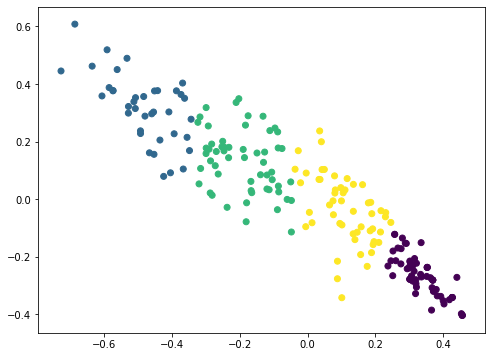

In [83]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
n_clusters = 4
np_c_sim = df[["R", "MK", "TC"]].values
model = KMeans(n_clusters=4).fit(np_c_sim)

plt.figure(figsize=(8, 6))
plt.scatter(np_c_sim[:,0], np_c_sim[:,1], c=model.labels_.astype(float))
print(model.labels_)
temp = df.index.to_numpy()
temp2 = df[["R", "MK", "TC"]]
data = []
for idx, uuid in enumerate(temp):
    row = [uuid, model.labels_[idx]]
    data.append(row)
c_sim_cluster_df = pd.DataFrame(data, columns=["User", f"C Sim Label - {n_clusters}"])
c_sim_cluster_df = c_sim_cluster_df.set_index("User")
c_sim_cluster_df= c_sim_cluster_df.join(temp2)
c_sim_cluster_df.to_csv("cluster.csv")